# Modeling neighborhoods and neighborhood types

In the urban studies, the subfield of **geodemographics** focuses on the use of cluster analysis to identify a typology of prototypical neighborhoods in a study region. Meanwhile, the subfield of **regionalization** focuses on identifying contiguous groups of spatial units whose internal attribute structure is relatively homogenous. Whereas geodemographics are concerned primarily with summarizing and categorizing neighborhoods, regionalization is concerned primarily with identifying and delineating neighborhoods. 

geosnap supports both of these goals by providing classic and spatial clustering algorithms as methods on the `Community` object

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from geosnap import Community, datasets

sns.set_context("notebook")

import warnings

warnings.filterwarnings("ignore")

Loading manifest: 100%|██████████| 3/3 [00:00<00:00, 3319.15entries/s]


## Modeling neighborhood types

To facilitate geodemographic and other neighborhood typologies, the `geosnap.analyze` module provides the `cluster` function, which is also implemented as a method on the `Community` class.

`cluster` takes a list of columns/variables, a clustering algorithm, and a number of clusters. It handles temporal clustering by splitting the dataset into decades and standardizing each variable, then re-pooling all the time periods back together before running the clustering algorithm on the full set of observations. This allows the distribution of each variable to evolve over time. It also allows neighborhood variables to move through different positions in the distrbution while providing a consistent set of clusters across time periods

In [2]:
columbusfips = datasets.msas()[
    datasets.msas().name.str.startswith("Columbus, OH")
].geoid.values[0]

In [3]:
columbus = Community.from_ltdb(msa_fips=columbusfips)

In [4]:
columbus = columbus.cluster(
    columns=[
        "median_household_income",
        "p_poverty_rate",
        "p_edu_college_greater",
        "p_unemployment_rate",
    ],
    method="ward",
)

SubplotsContainer([CartesianAxesSubplot(0.0563557,0.351445;0.282221x0.591327), CartesianAxesSubplot(0.377369,0.351445;0.282221x0.591327), CartesianAxesSubplot(0.698383,0.351445;0.282221x0.591327)])

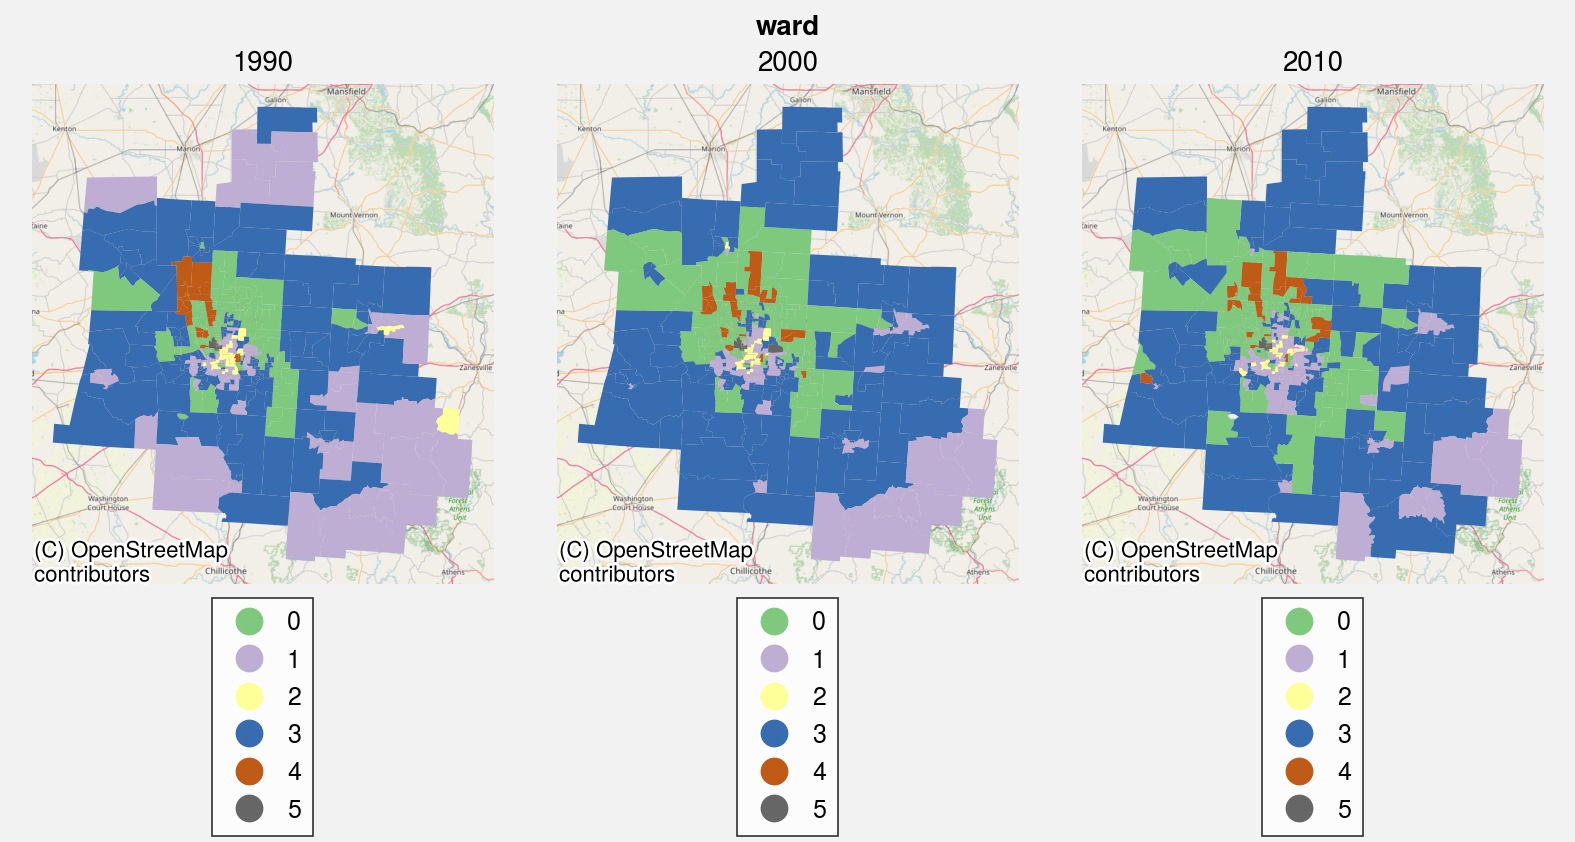

In [5]:
columbus.plot_timeseries(
    "ward", years=[1990, 2000, 2010], categorical=True, cmap="Accent"
)

`cluster` returns a `Community` class with cluster labels appended as a new column on the underlying geodataframe. This makes it simple to visualize how the clusters have evolved in space over time

SubplotsContainer([CartesianAxesSubplot(0.0563557,0.322186;0.282221x0.618005), CartesianAxesSubplot(0.377369,0.322186;0.282221x0.618005), CartesianAxesSubplot(0.698383,0.322186;0.282221x0.618005)])

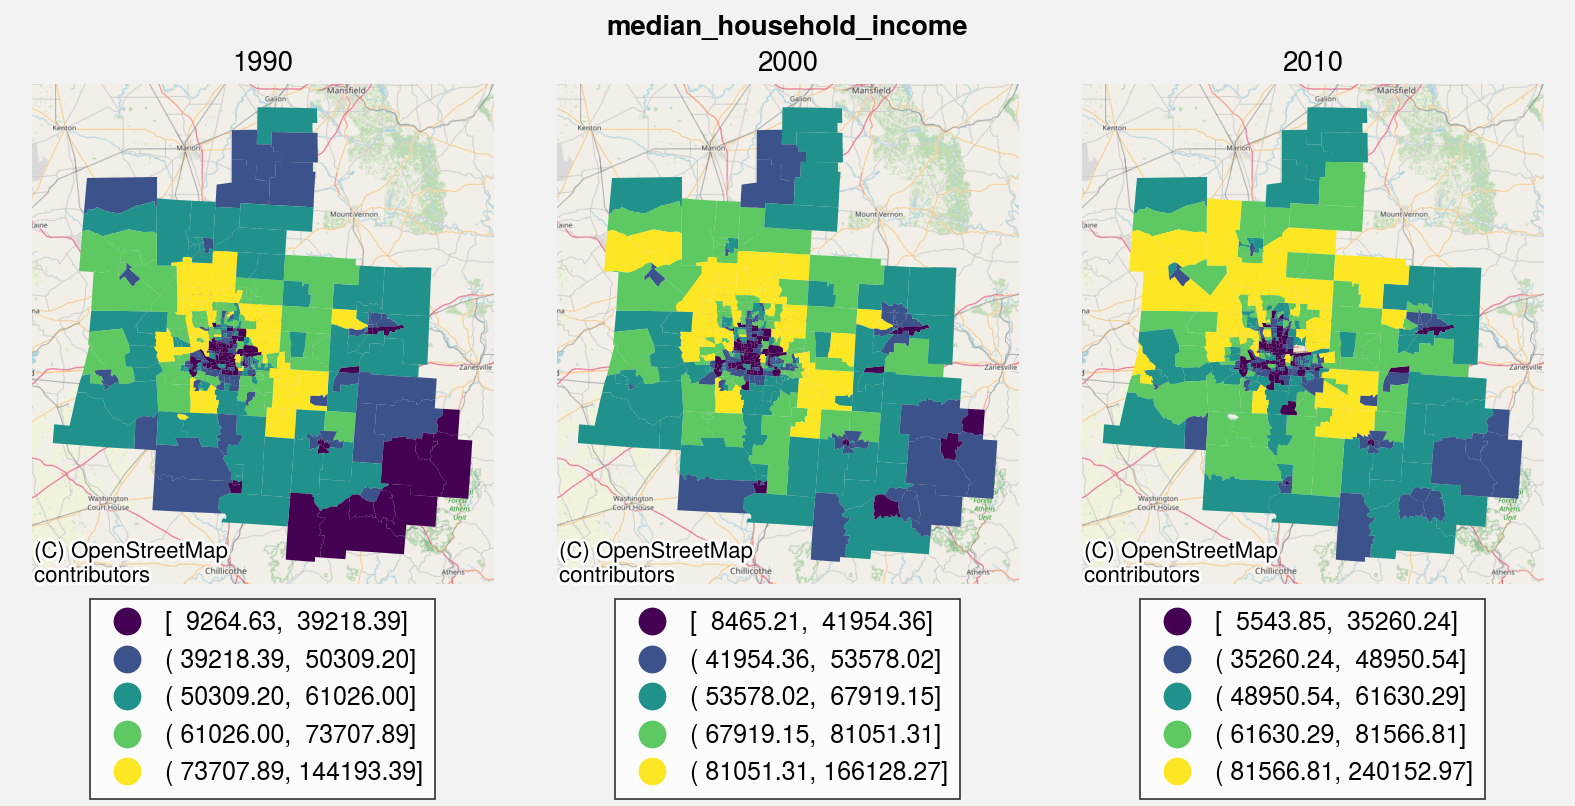

In [6]:
columbus.plot_timeseries(
    "median_household_income", years=[1990, 2000, 2010], cmap="viridis"
)

Since cluster labels are appended to the input database, it's also simple to compute and visualize statistics by cluster, even for variables that weren't used to derive the clusters

In [7]:
columbus.gdf.groupby("ward")["p_nonhisp_white_persons"].median()

ward
0    92.849963
1    81.712362
2    26.917546
3    95.743874
4    94.202012
5    82.809803
Name: p_nonhisp_white_persons, dtype: float64

<AxesSubplot:xlabel='ward', ylabel='p_nonhisp_black_persons'>

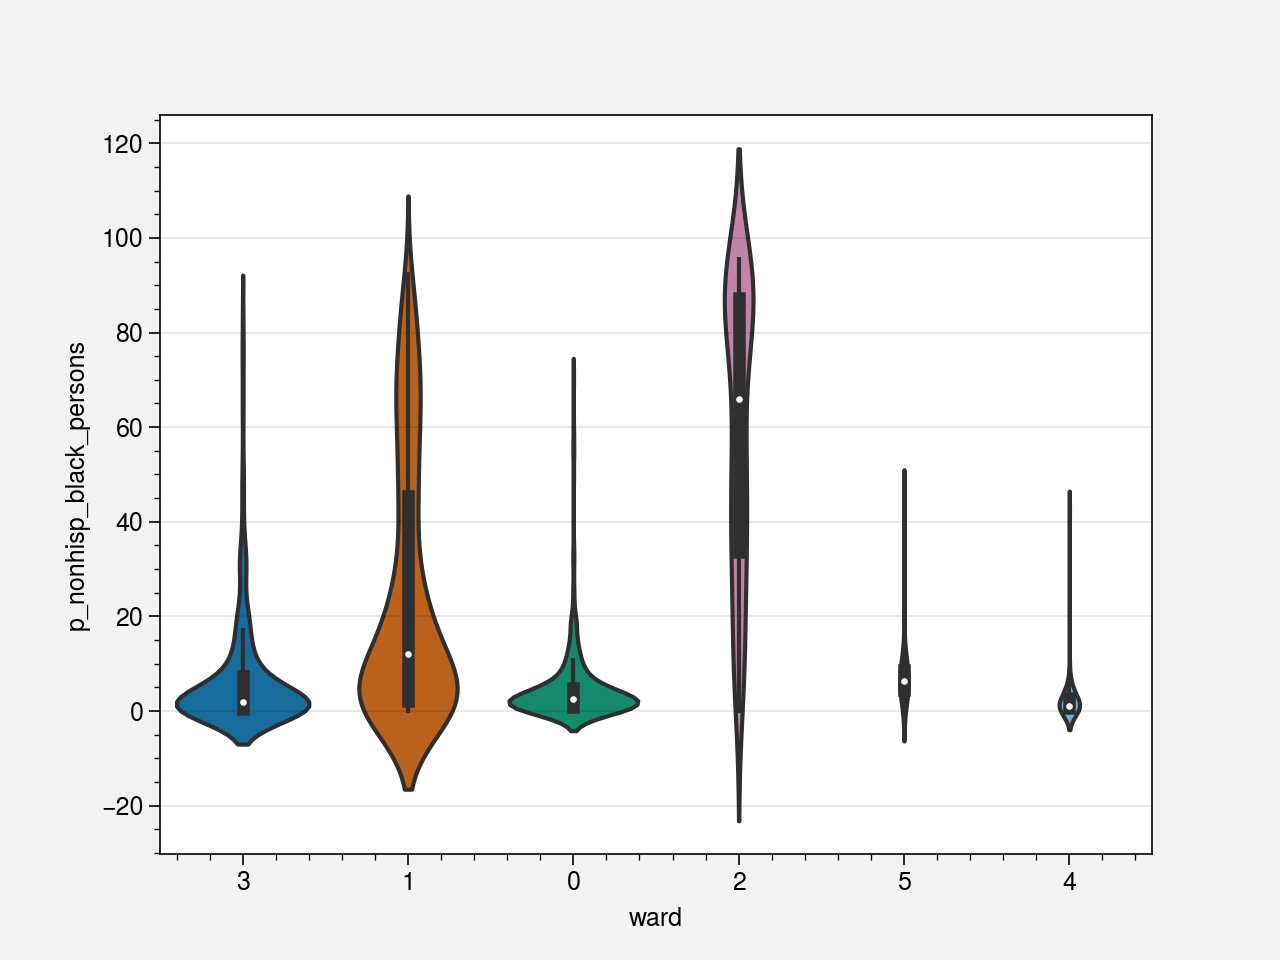

In [8]:
sns.violinplot(x="ward", y="p_nonhisp_black_persons", data=columbus.gdf, scale="count")

In [9]:
types = ["kmeans", "affinity_propagation", "gaussian_mixture", "spectral", "hdbscan"]

Since there are many different clusting algorithms available, you can examine how their solutions differ for the same set of input variables

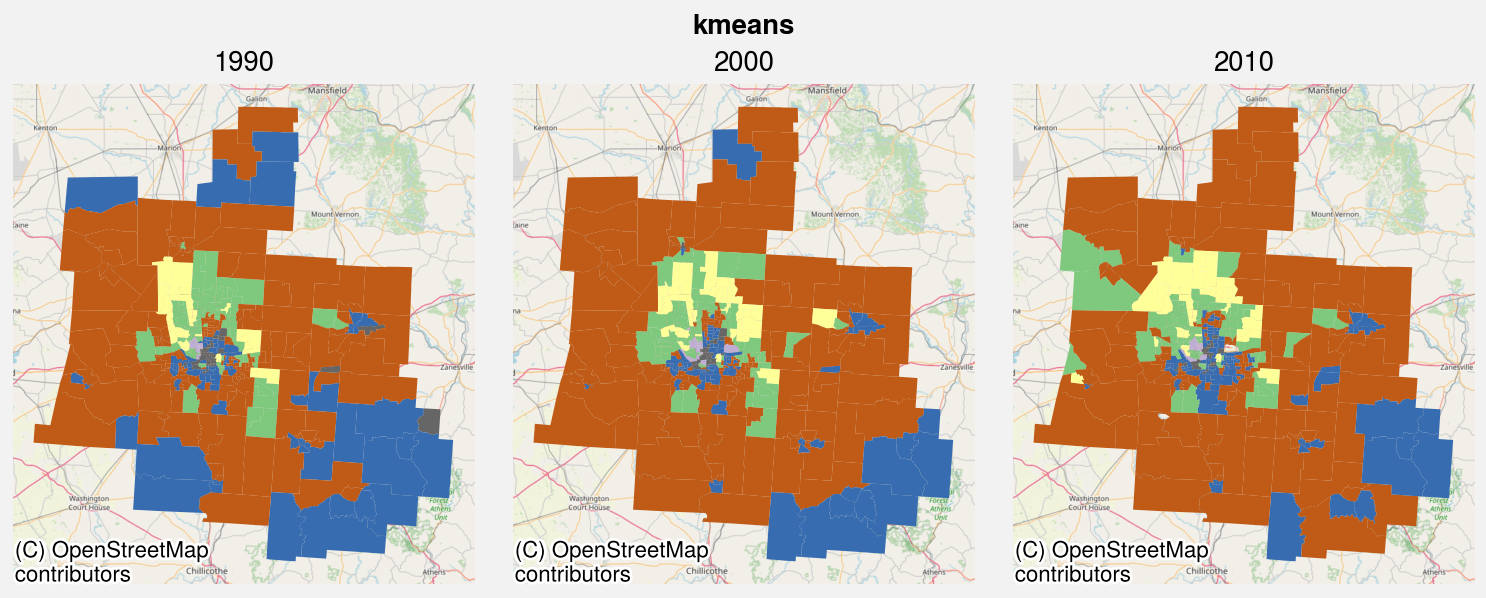

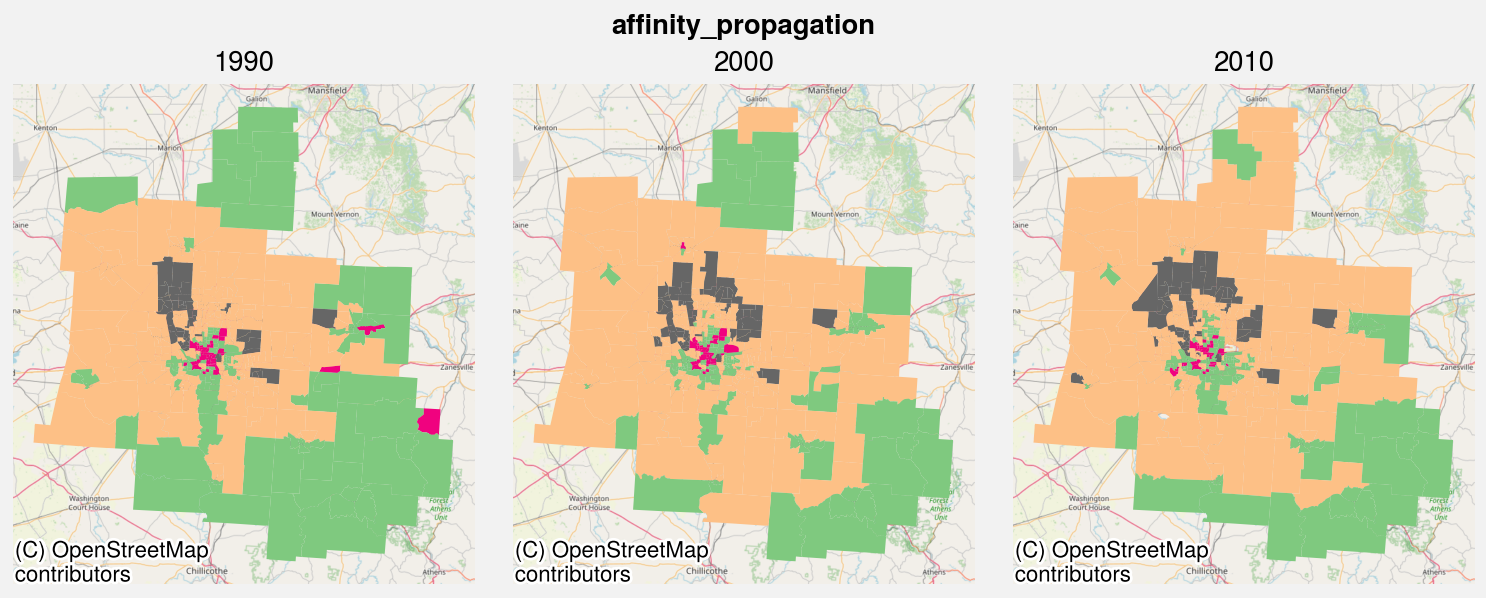

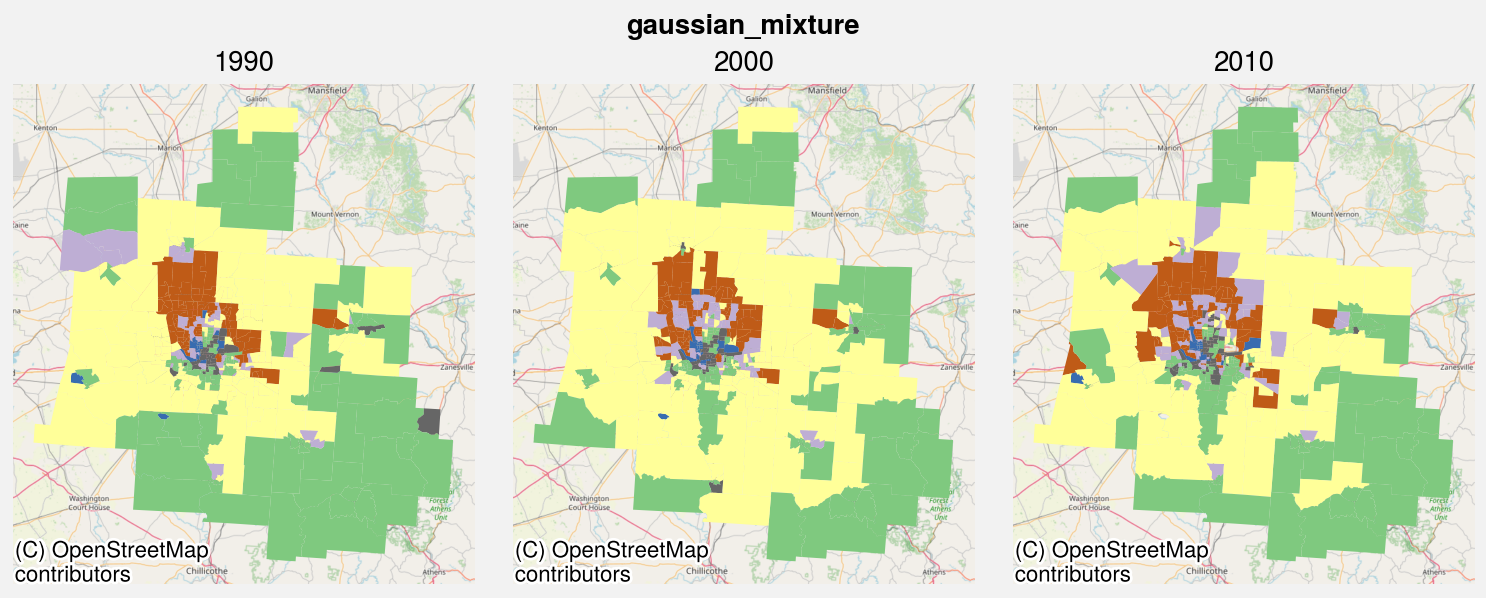

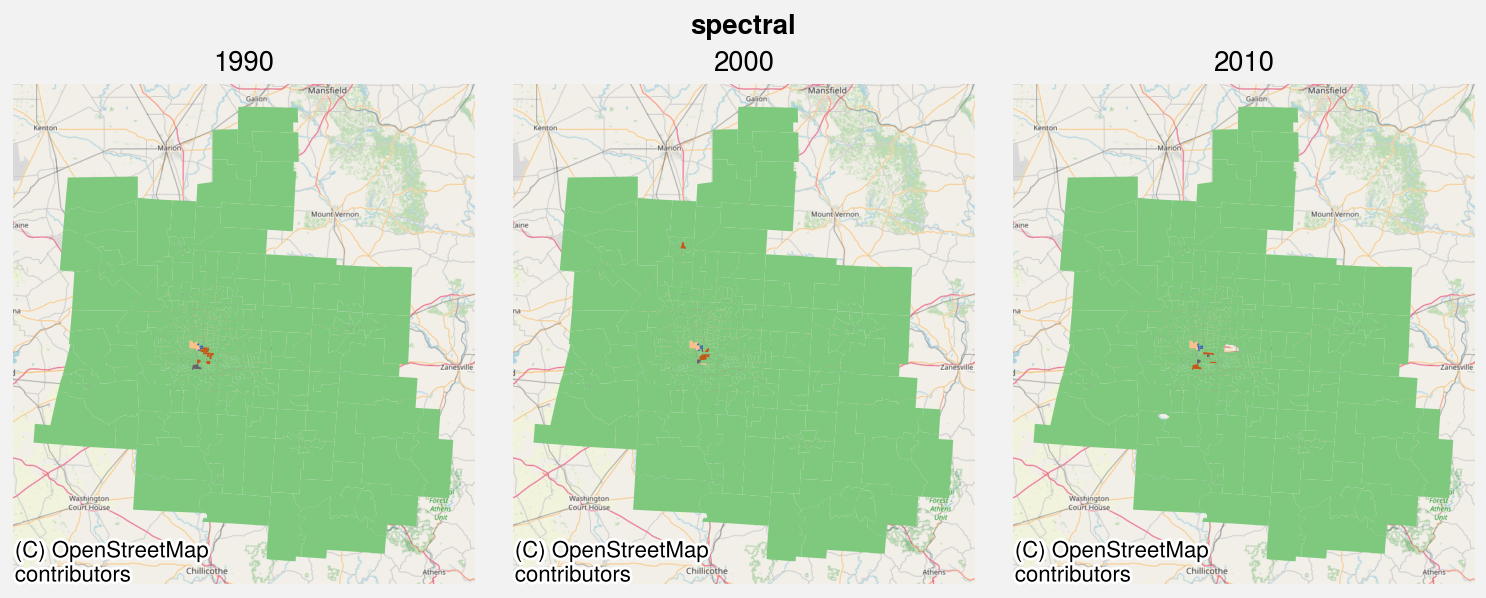

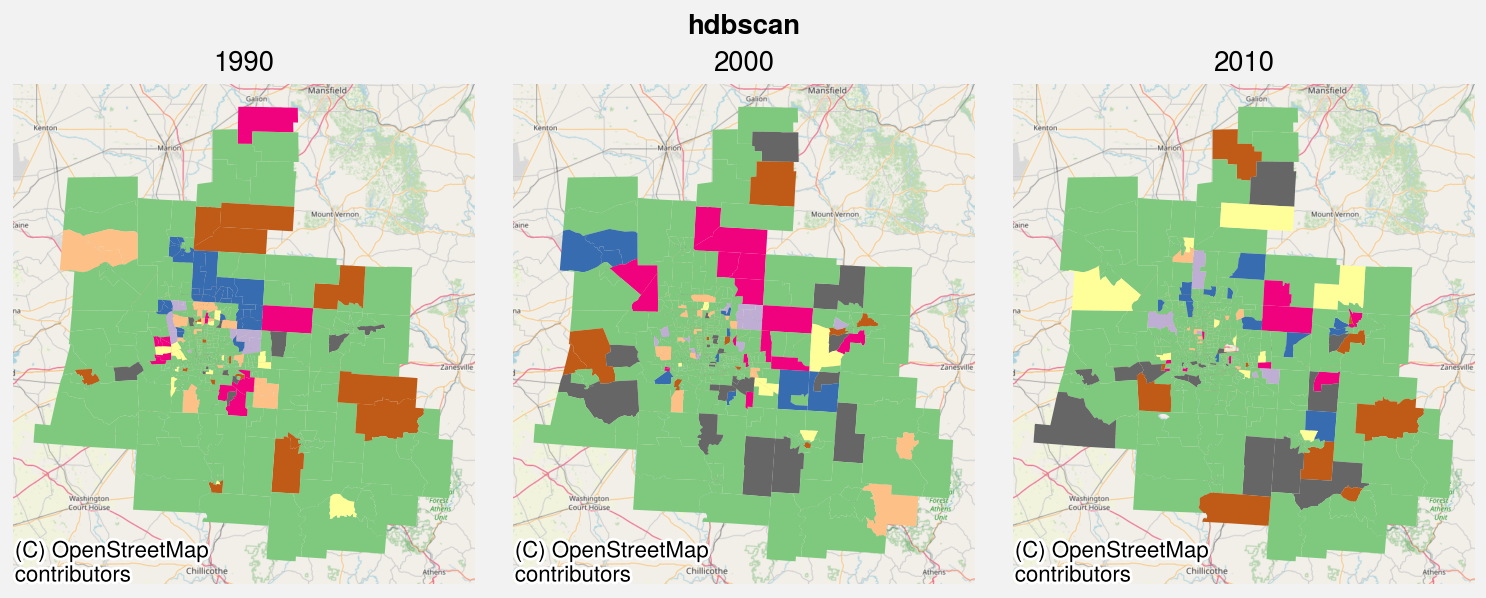

In [10]:
for algo in types:

    columbus = columbus.cluster(
        columns=[
            "median_household_income",
            "p_poverty_rate",
            "p_edu_college_greater",
            "p_unemployment_rate",
        ],
        method=algo,
    )
    columbus.plot_timeseries(
        column=algo,
        years=[1990, 2000, 2010],
        cmap="Accent",
        categorical=True,
        legend=False,
        alpha=0.6
    )

## Modeling neighborhoods

If use use the `cluster_spatial` method instead of the classic `cluster` method, we adopt the regionalization approach, assuming that each observation in smaller than a single "neighborhood", and aggregate them into bespoke neighborhoods that are internally similar.

Here again, we offer several different spatial clustering algorithms, each of which produces a distinct result

In [11]:
spatial_types = [
    "azp",
    "ward_spatial",
    "skater",
    "max_p",
]  # spenc is temporarily removed

In [ ]:
import contextily as ctx

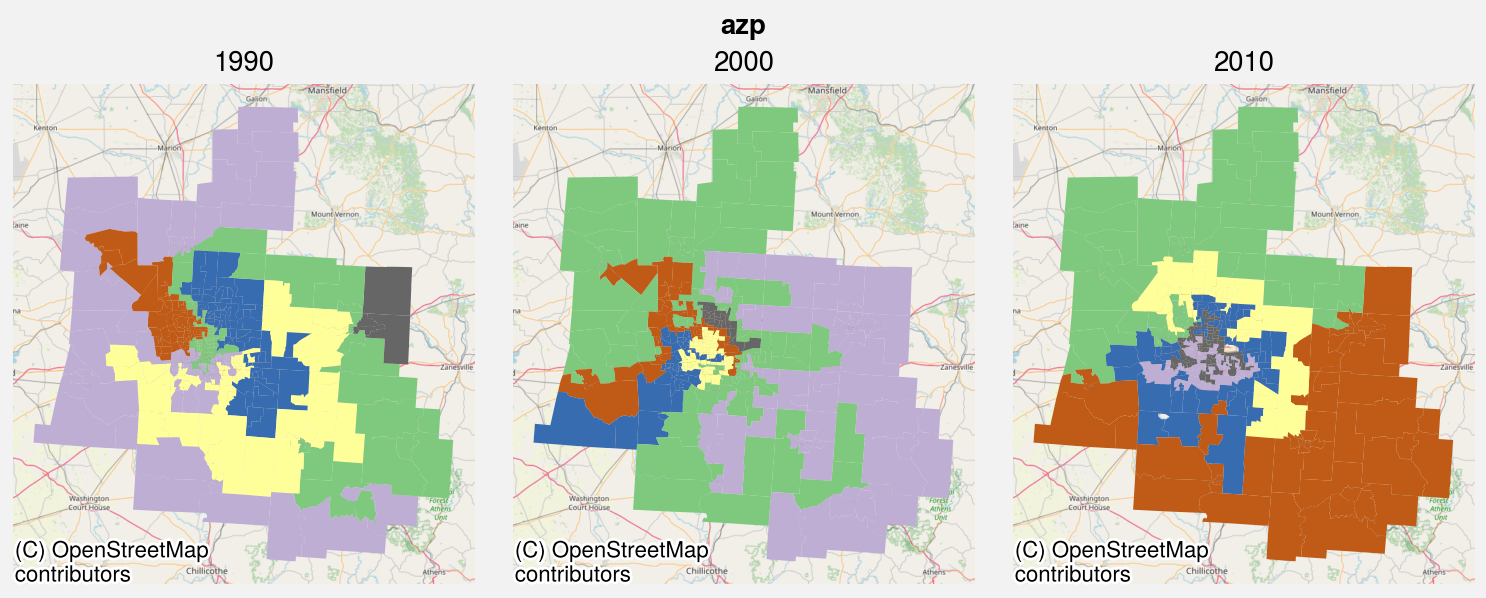

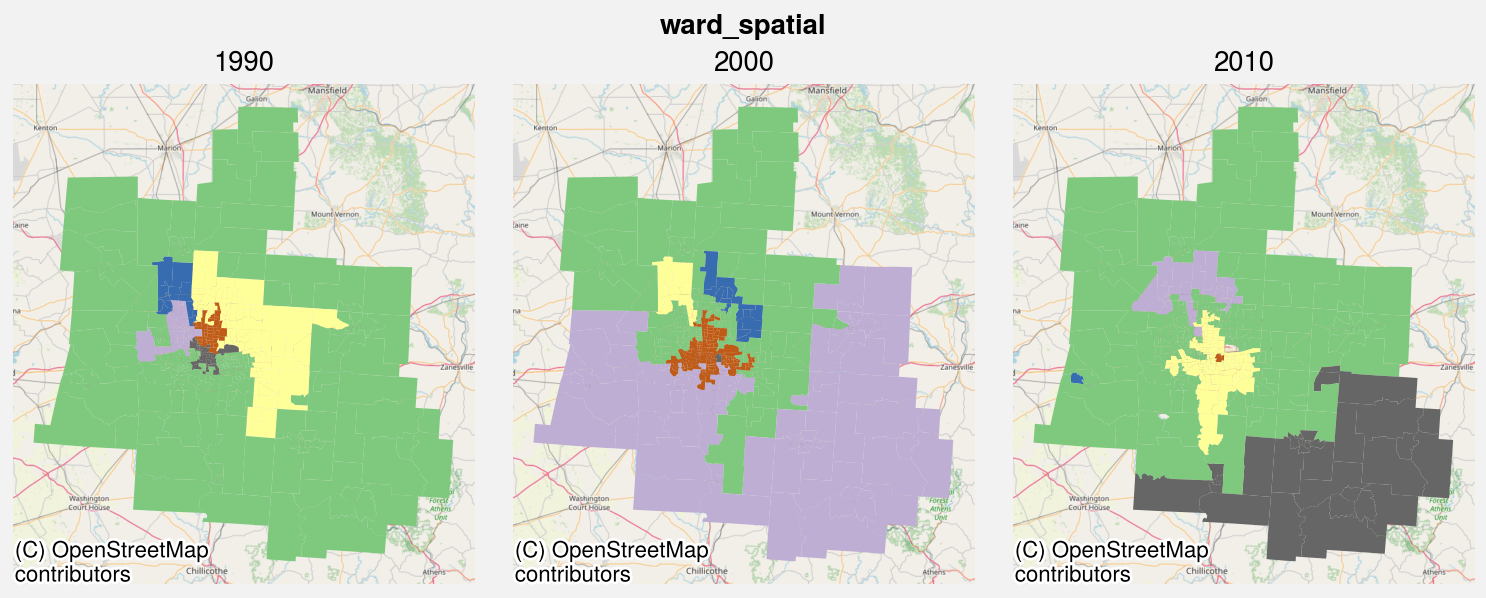

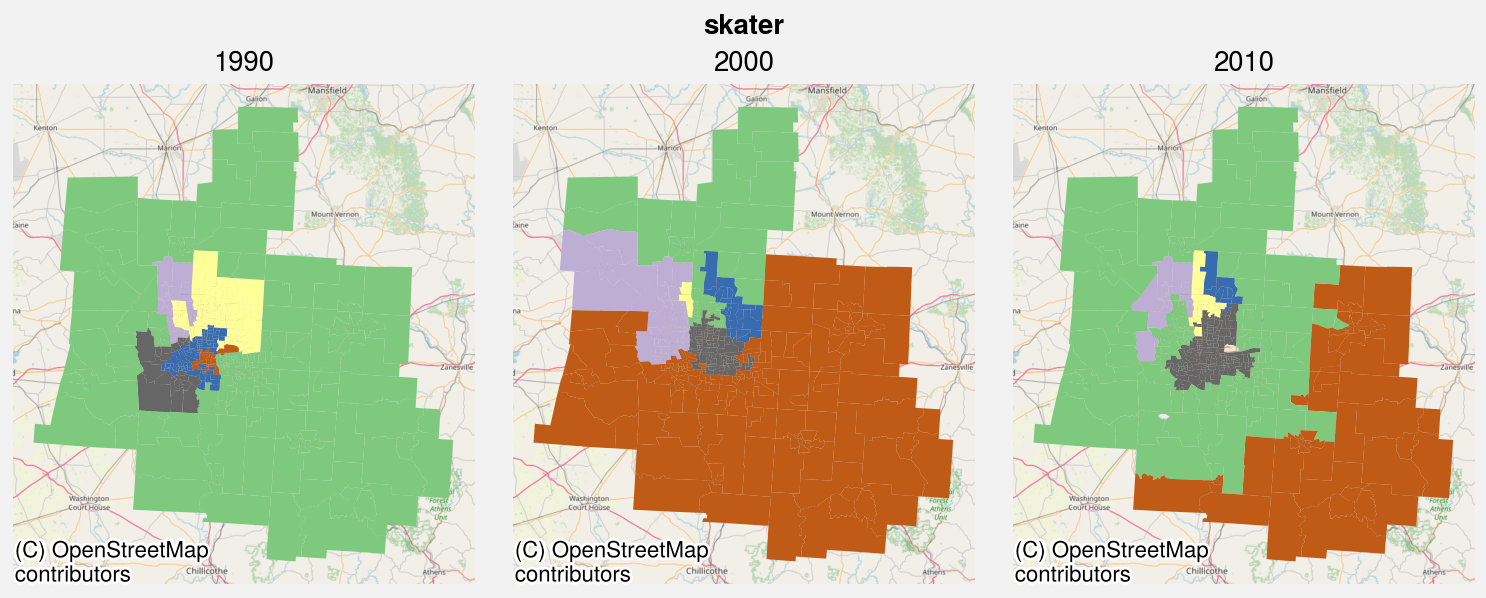

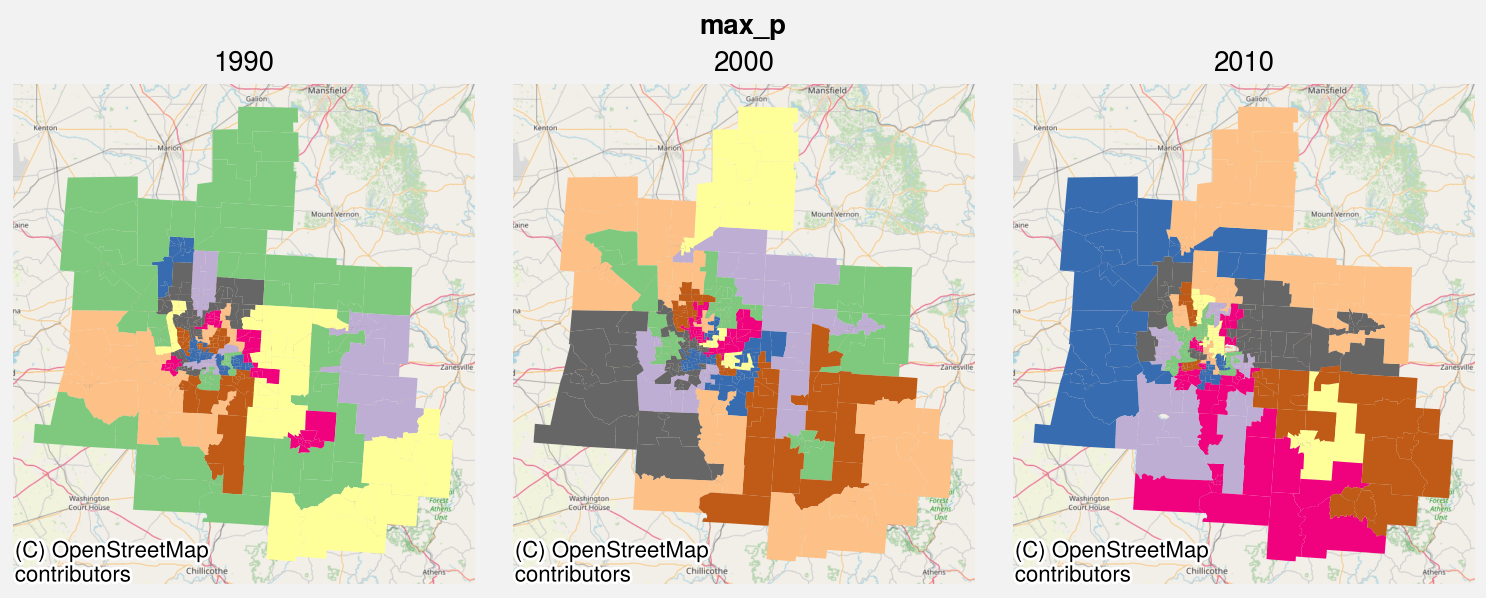

In [12]:
sys.stdout = open(os.devnull, "w")  # Disable printring because of max_p's diagnostics

for algo in spatial_types:

    columbus = columbus.cluster_spatial(
        columns=[
            "median_household_income",
            "p_poverty_rate",
            "p_edu_college_greater",
            "p_unemployment_rate",
        ],
        method=algo,
    )
    columbus.plot_timeseries(
        algo, cmap="Accent", years=[1990, 2000, 2010], categorical=True, legend=False,
        alpha=0.5
        ctxmap=
    )

## Examining Model Fit

Each time a cluster model is fitted to `Community` data, the results and some metadata are stored on the `Community.models` attribute, which is a dictionary keyed on the model name

for models with `pooling==unique`, the value in `models` is a dictionary of `ModelResults` keyed on year

In [13]:
columbus.models

{'ward': <geosnap.analyze.analytics.ModelResults at 0x7fd5b80d2f50>,
 'kmeans': <geosnap.analyze.analytics.ModelResults at 0x7fd629944390>,
 'affinity_propagation': <geosnap.analyze.analytics.ModelResults at 0x7fd6188aa450>,
 'gaussian_mixture': <geosnap.analyze.analytics.ModelResults at 0x7fd66c0167d0>,
 'spectral': <geosnap.analyze.analytics.ModelResults at 0x7fd649026bd0>,
 'hdbscan': <geosnap.analyze.analytics.ModelResults at 0x7fd5b84c6310>,
 'azp': {1970: <geosnap.analyze.analytics.ModelResults at 0x7fd6299e06d0>,
  1980: <geosnap.analyze.analytics.ModelResults at 0x7fd6186e5150>,
  1990: <geosnap.analyze.analytics.ModelResults at 0x7fd65906efd0>,
  2000: <geosnap.analyze.analytics.ModelResults at 0x7fd6441c9650>,
  2010: <geosnap.analyze.analytics.ModelResults at 0x7fd6441c94d0>},
 'ward_spatial': {1970: <geosnap.analyze.analytics.ModelResults at 0x7fd659288410>,
  1980: <geosnap.analyze.analytics.ModelResults at 0x7fd629304d10>,
  1990: <geosnap.analyze.analytics.ModelResults a

For community of the entries in the `models` dictionary is an instance of the `ModelResults` class

In [14]:
dir(columbus.models["ward"])

['W',
 'X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'boundary_sil',
 'boundary_silhouettes',
 'columns',
 'instance',
 'labels',
 'model_type',
 'nearest_label',
 'nearest_labels',
 'path_sil',
 'path_silhouettes',
 'sil_scores',
 'silhouettes']

Each instance of `ModelResults` holds 
- the input data (`X`), 
- the resulting labels of each input geometry (`labels`), 
- the column names from the Community `gdf` used to fit the model, 
- the libpysal spatial weights matrix used in the model (`W`) (if necessary) 
- the fitted model instance itself (`instance`) in case the analyst needs to pull any additional metadata from the object

and some additional silhouette and geosilhouette statistics that can be used to evaluate model fit.

### Plotting Model Diagnostics

<AxesSubplot:title={'center':'Silhouette Analysis'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

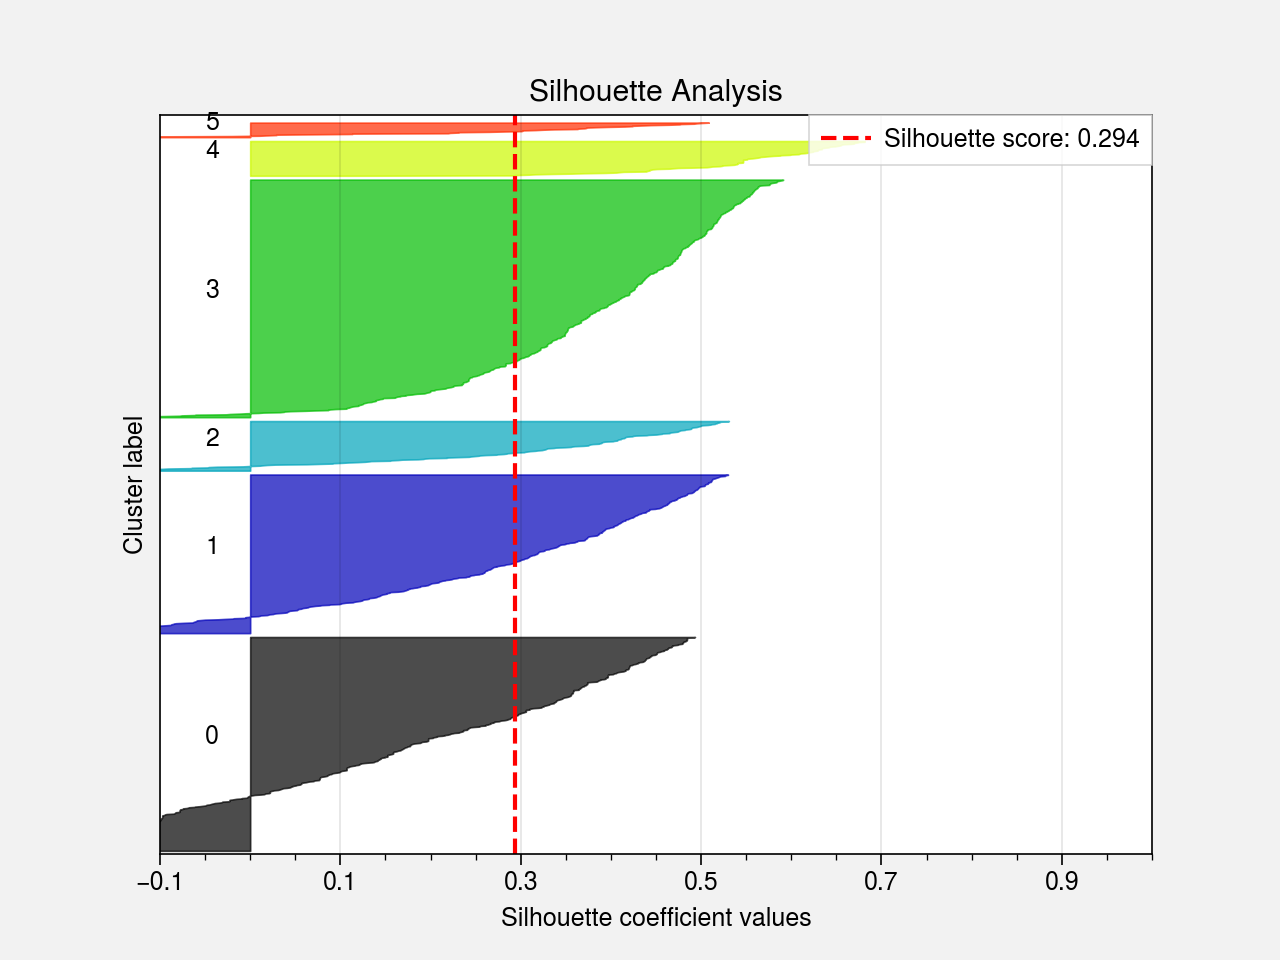

In [15]:
columbus.plot_silhouette("ward")

<AxesSubplot:title={'center':'Silhouette Analysis'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

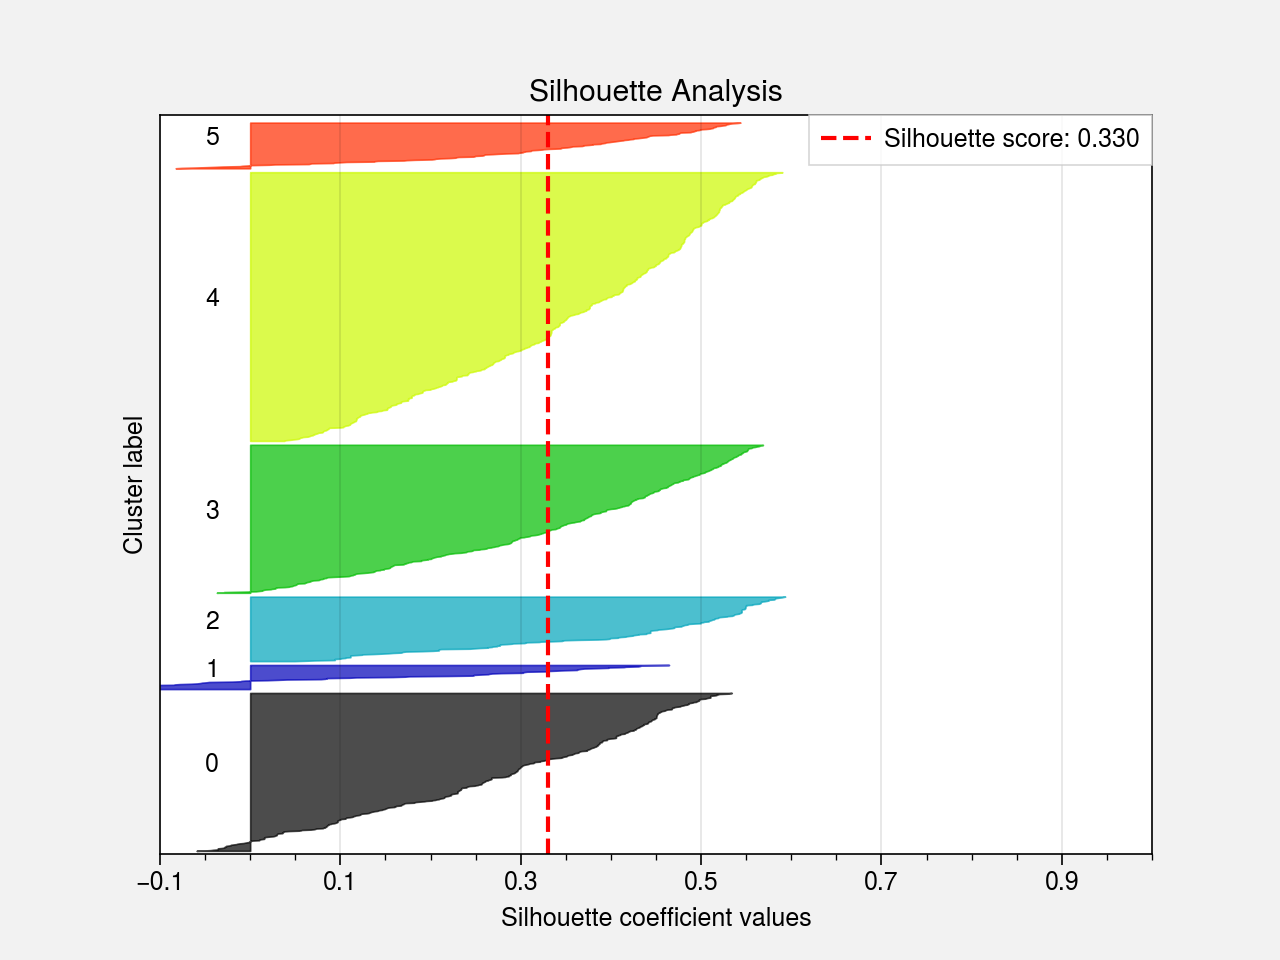

In [16]:
columbus.plot_silhouette("kmeans")

<AxesSubplot:title={'center':'Silhouette Analysis'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

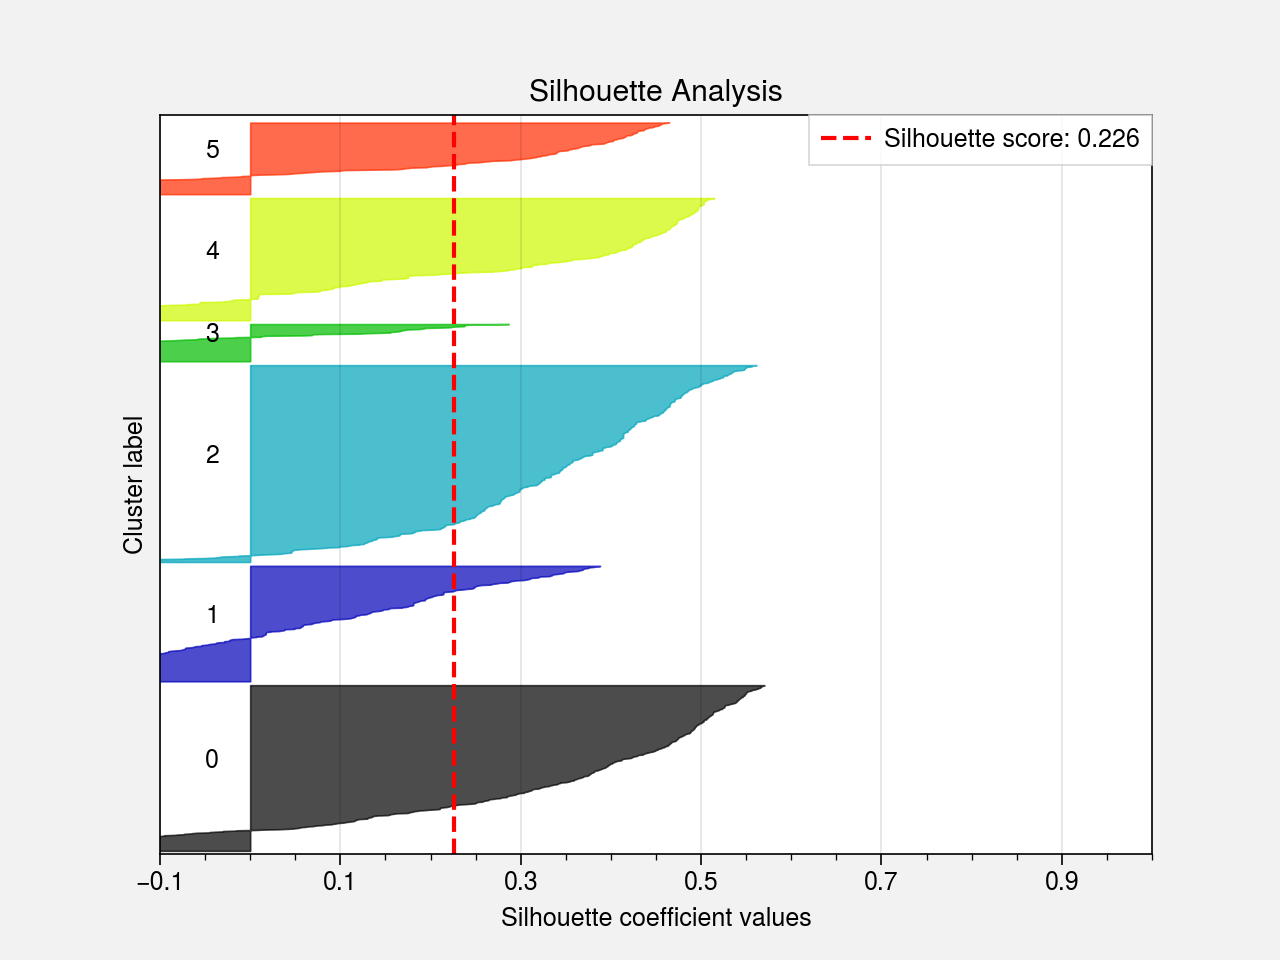

In [17]:
columbus.plot_silhouette("gaussian_mixture")

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

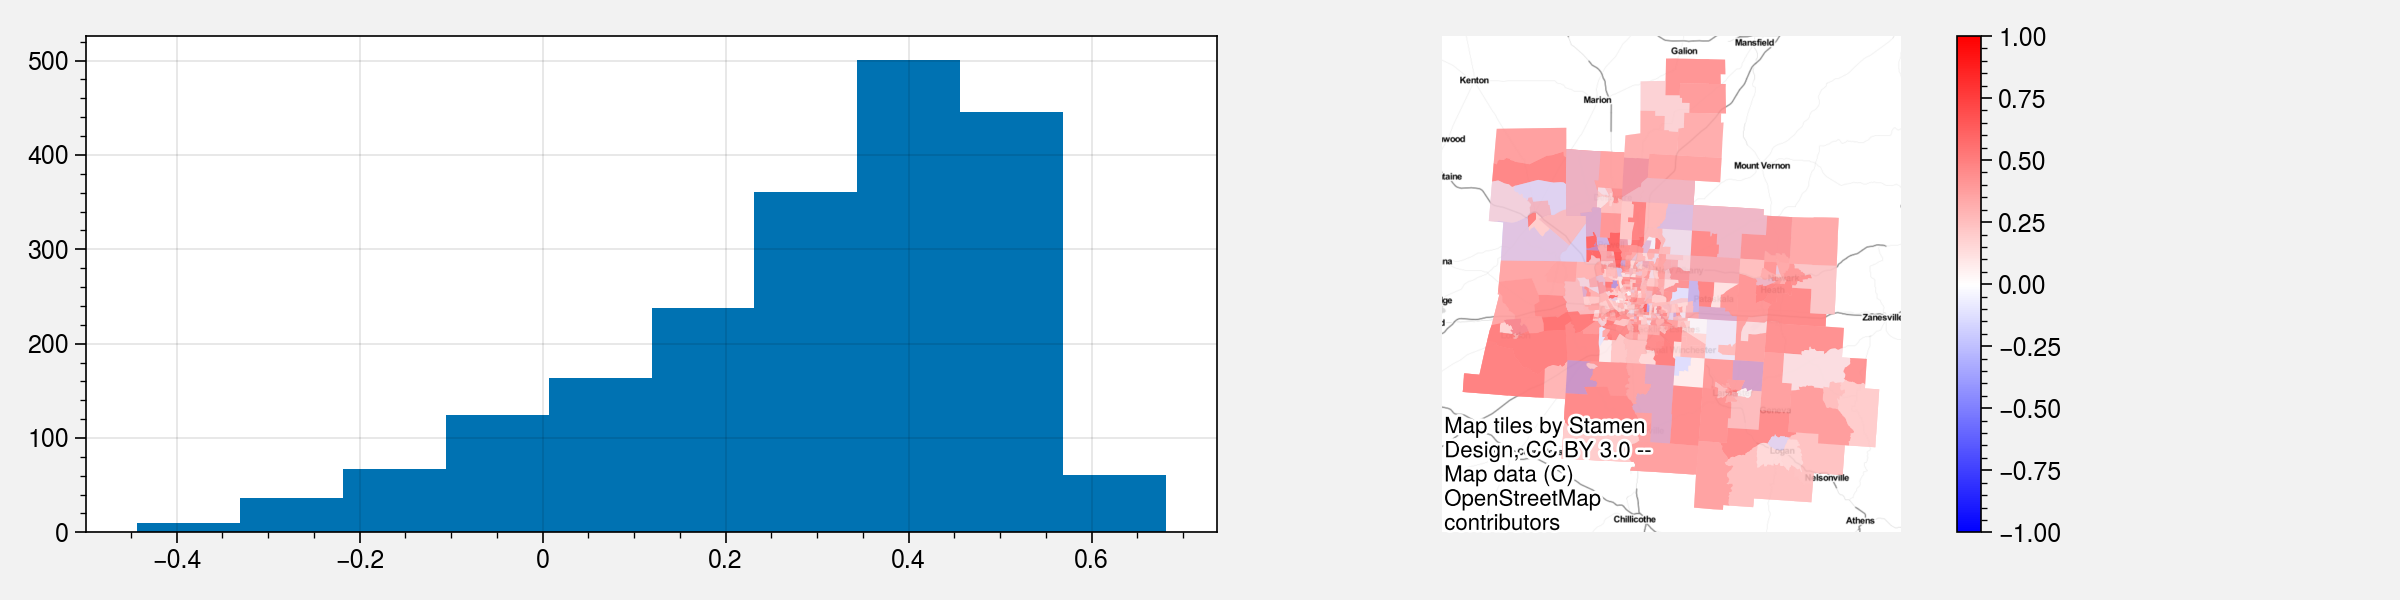

In [18]:
columbus.plot_silhouette_map("ward")

For spatial models, or any cluster where temporal data are not pooled, include a year argument to see the model fit for that time period

<AxesSubplot:title={'center':'Silhouette Analysis'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

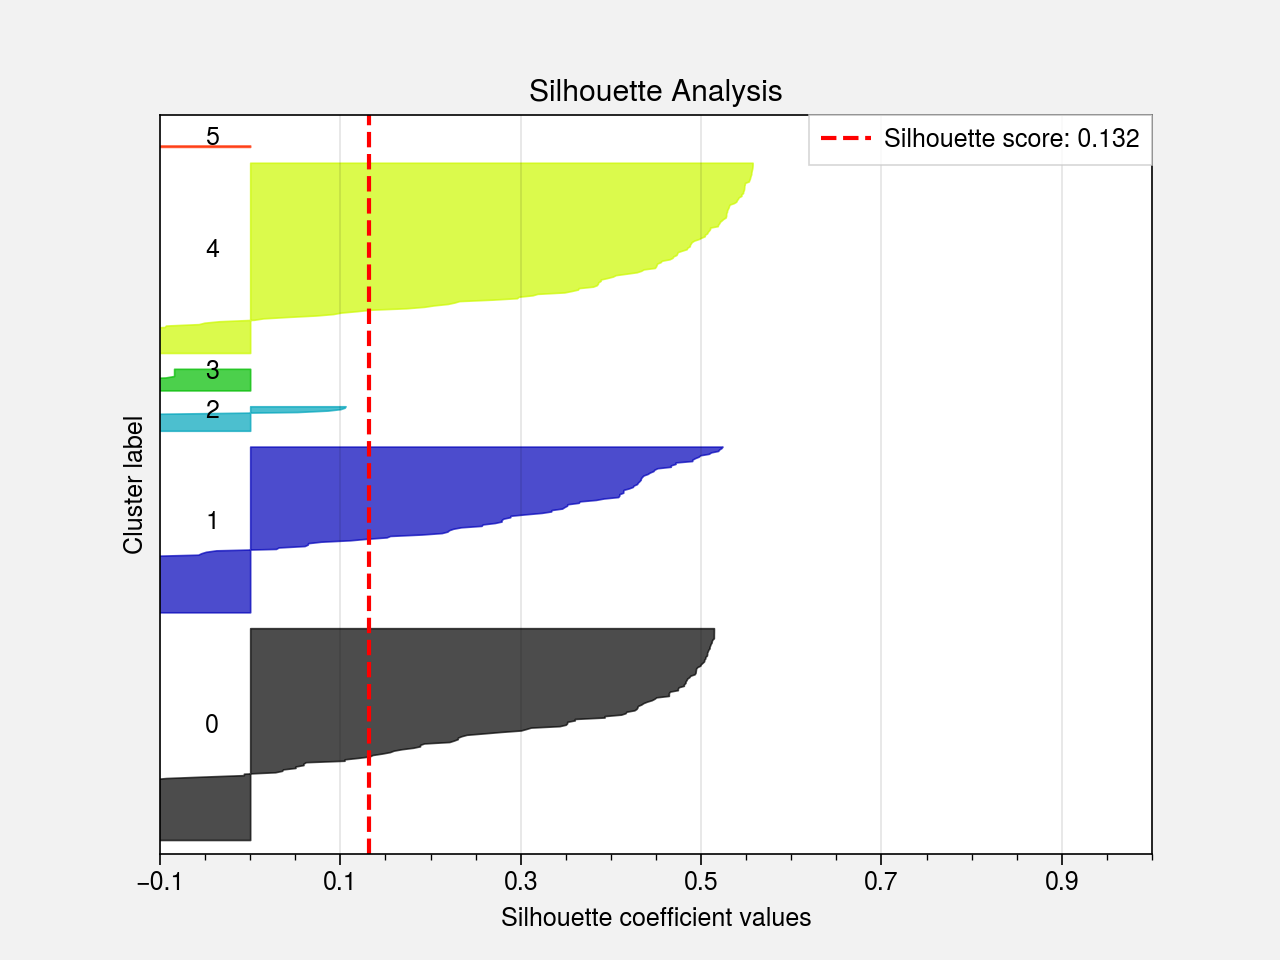

In [19]:
columbus.plot_silhouette("ward_spatial", year=2000)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

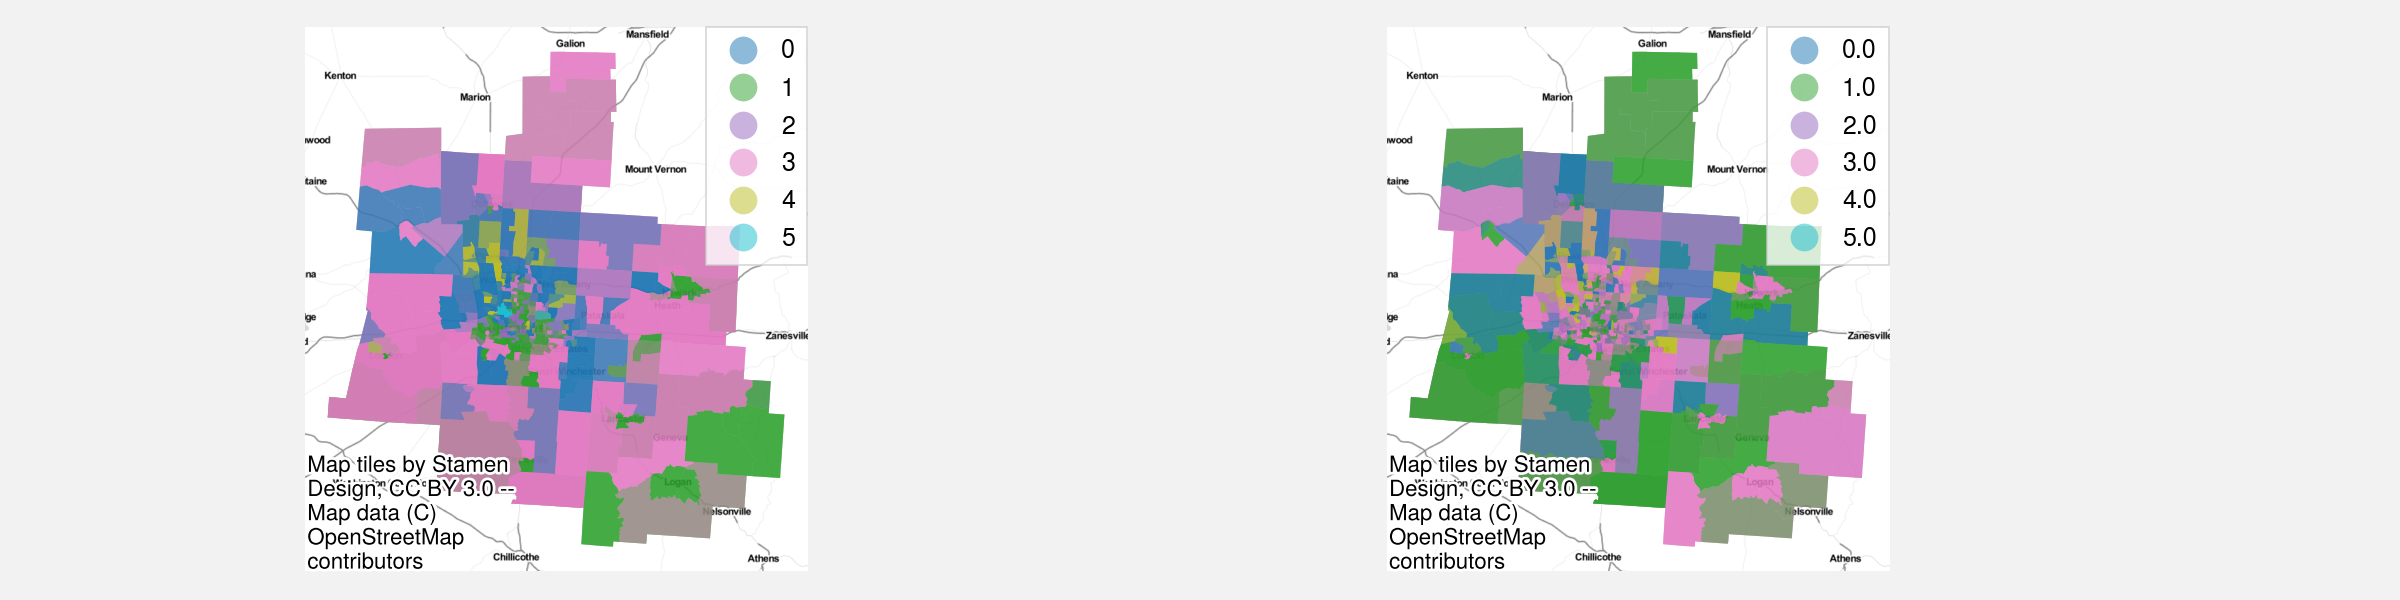

In [20]:
columbus.plot_next_best_label("ward")

Spatial cluster models also have some additional visualization methods available based on [geosilhouettes](https://journals.sagepub.com/doi/10.1177/2399808319875752)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

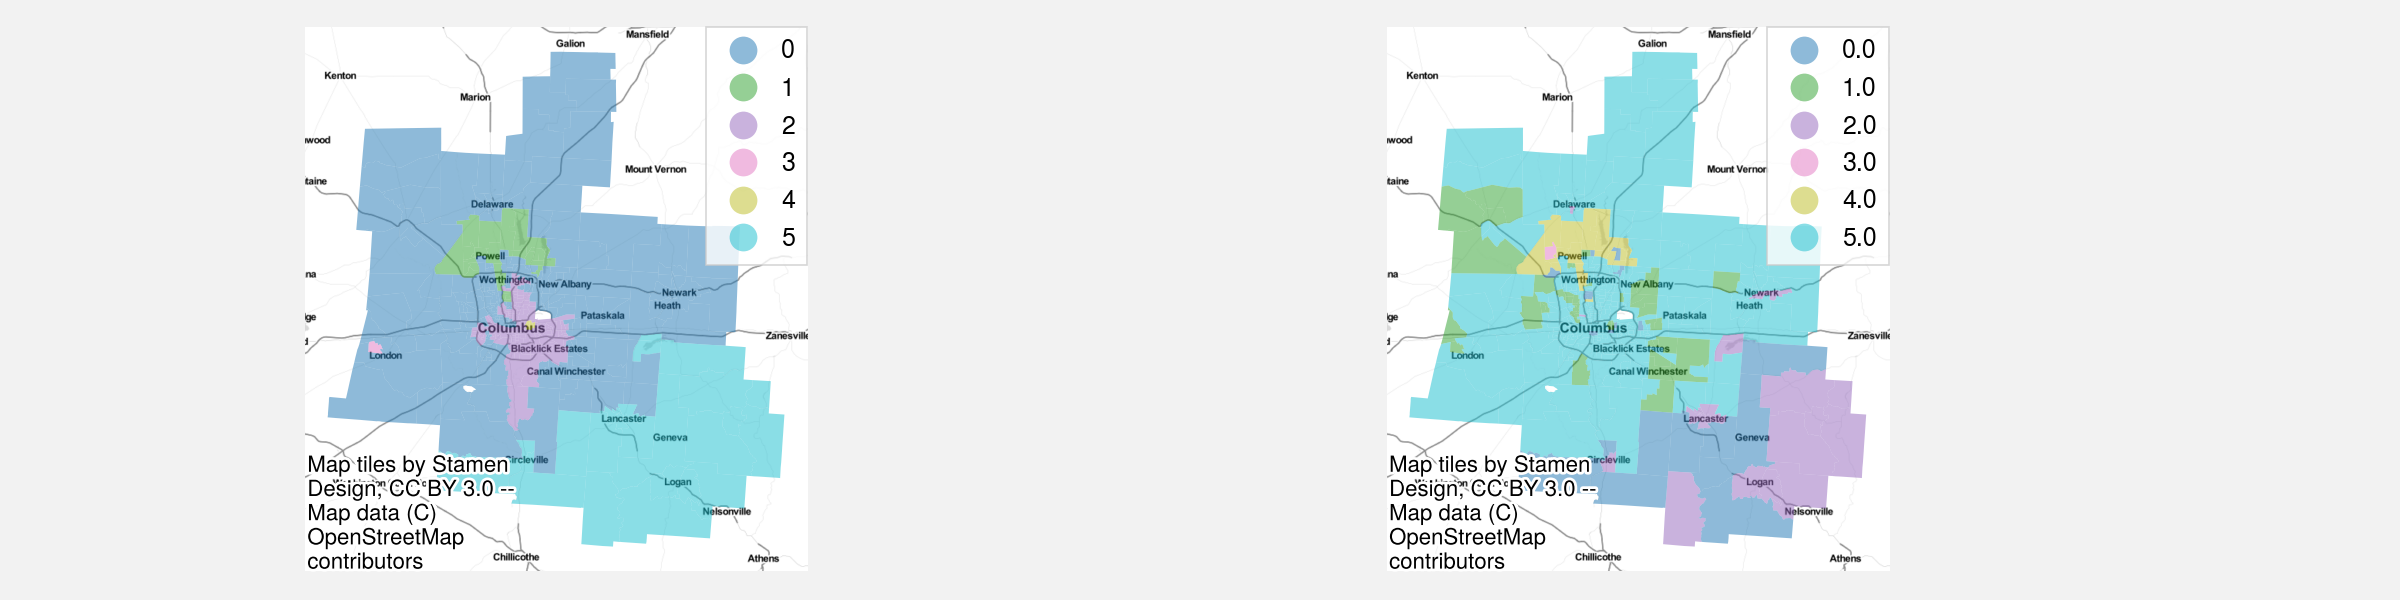

In [21]:
columbus.plot_next_best_label("ward_spatial", year=2010)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

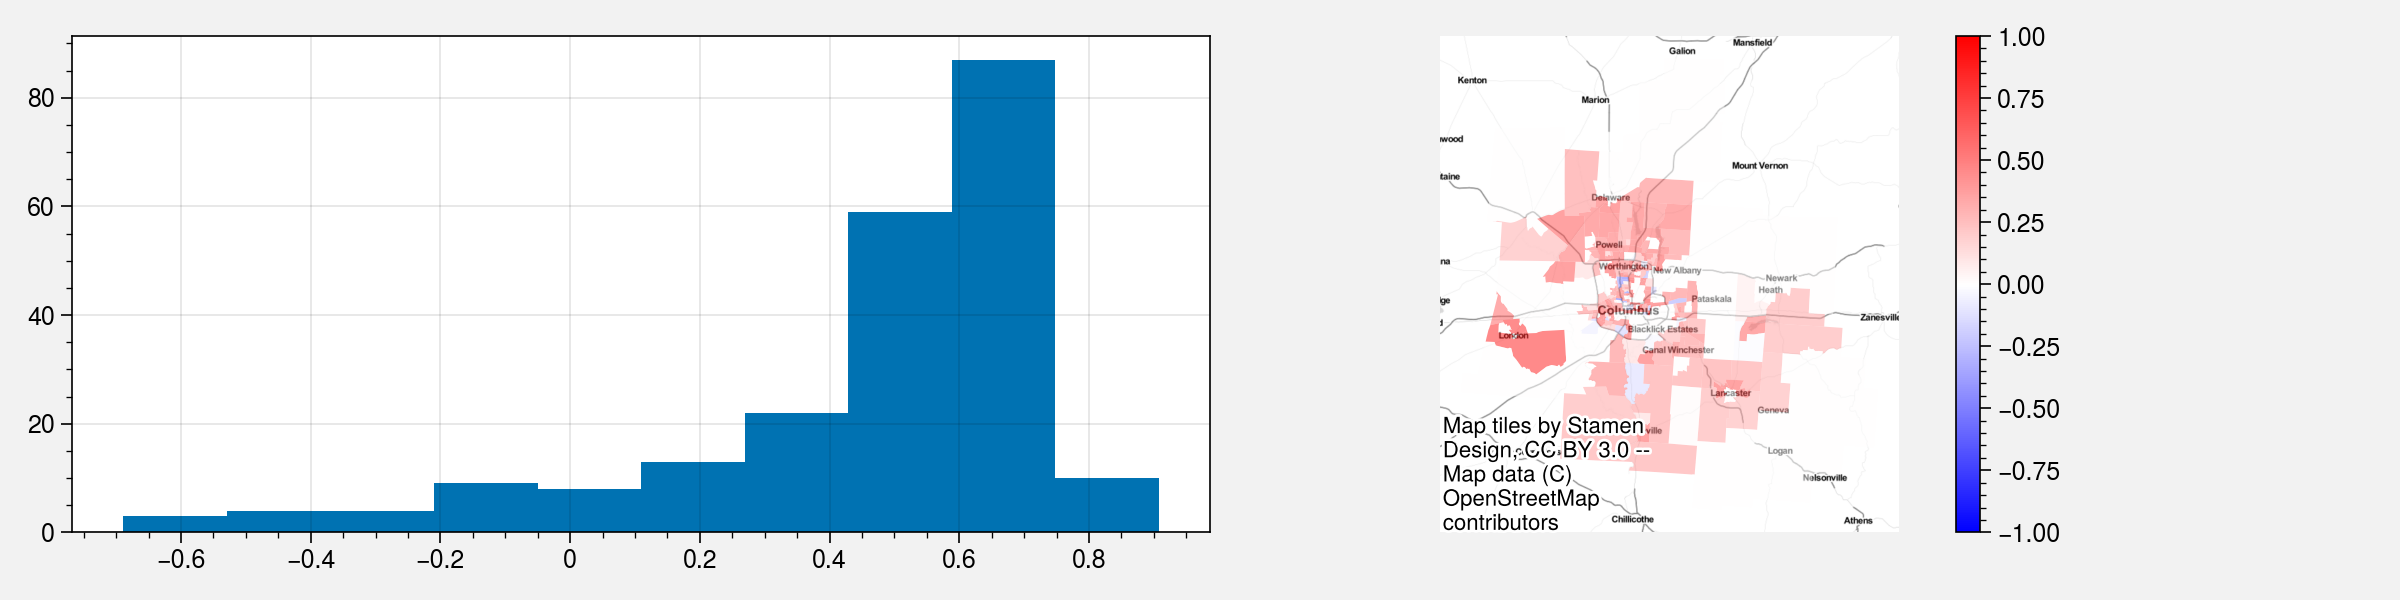

In [22]:
columbus.plot_boundary_silhouette("ward_spatial", year=2010)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

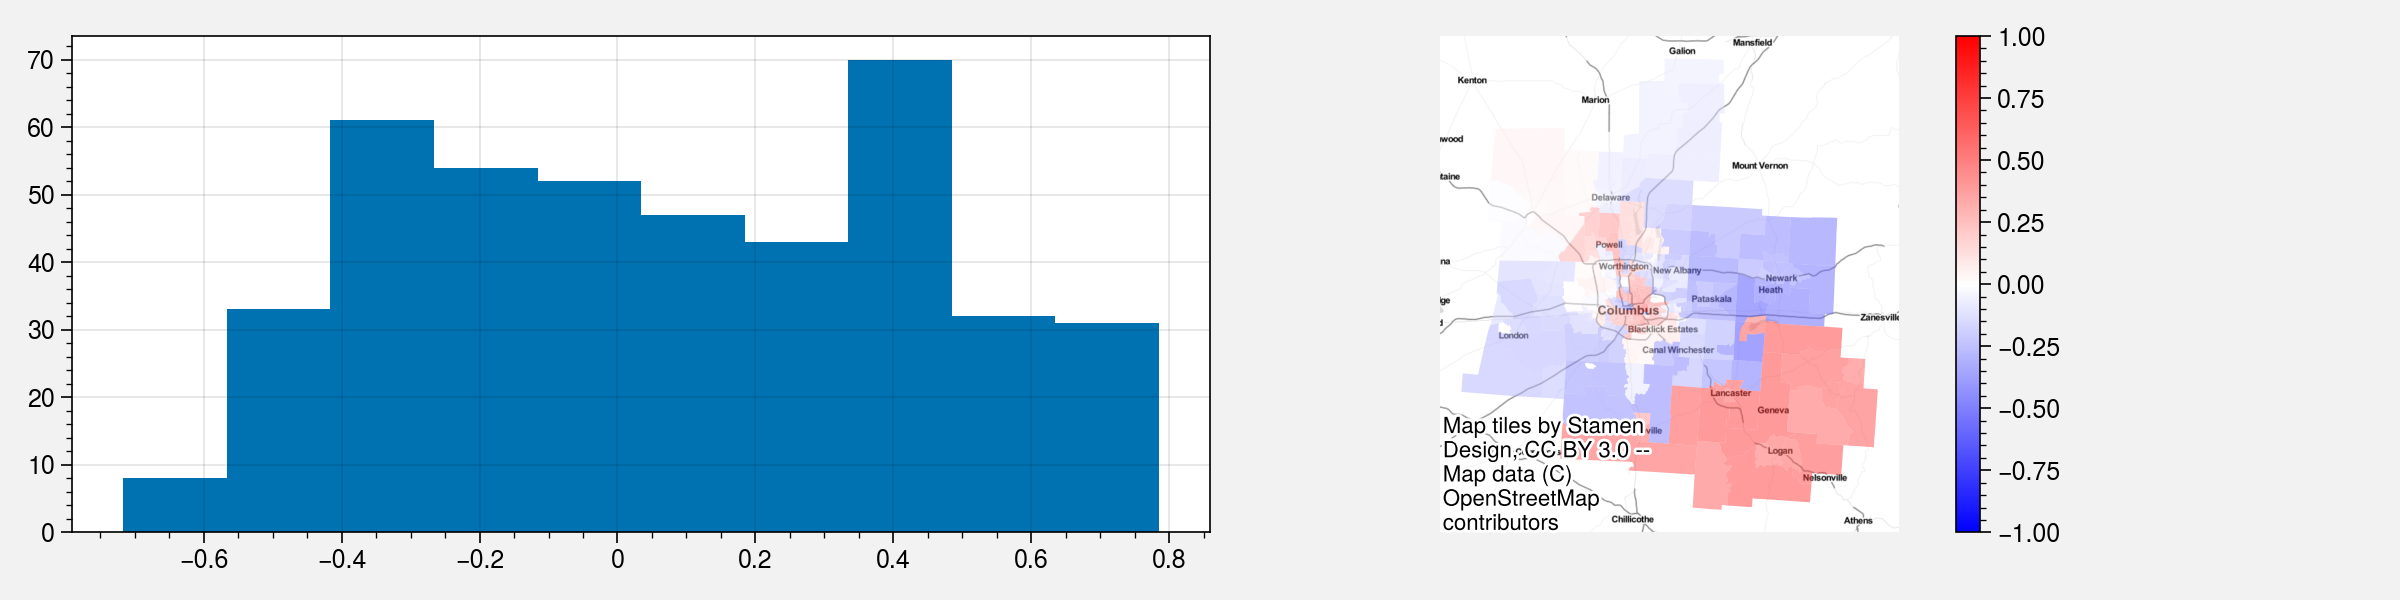

In [23]:
columbus.plot_path_silhouette("ward_spatial", year=2010)